In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/479_706.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/481_469.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/184_205.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/315_322.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/645_688.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/700_813.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/313_283.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/336_338.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/746_571.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/917_924.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/207_908.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/297_270.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/692_610.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/179_212.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/936_931.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/562_

In [2]:
!pip install facenet-pytorch

In [4]:
import os
import cv2
import glob
import random
import shutil
import numpy as np
from tqdm import tqdm
import torch
from facenet_pytorch import MTCNN

# ==========================================
# 🔧 CONFIGURATION
# ==========================================
DATA_ROOT = "/kaggle/working/Final_Active_Dataset"
IMG_SIZE = 224
SEQ_LENGTH = 20        # Frames per video
MARGIN_FACTOR = 1.3    # Loose Crop
DETECT_SIZE = 640      # Resize to this width for detection (Speed Hack)
MAX_VIDEO_SIZE_MB = 4  # 🚨 NEW: Skip videos larger than 4MB

# Split Ratios
SPLITS = {"train": 0.8, "val": 0.1, "test": 0.1}

# Paths
FF_REAL = "/kaggle/input/ff-c23/FaceForensics++_C23/original"
FF_FAKE = "/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes"
CELEB_REAL = "/kaggle/input/celeb-df-v2/Celeb-real"
CELEB_FAKE = "/kaggle/input/celeb-df-v2/Celeb-synthesis"

# Setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Turbo-Active Extractor running on: {device}")

# Initialize MTCNN
mtcnn = MTCNN(keep_all=False, device=device, post_process=False)

# ==========================================
# 1. SMART "ACTIVE" FRAME SELECTOR
# ==========================================
def get_active_frames(video_path, max_frames=20):
    cap = cv2.VideoCapture(video_path)
    frames = []
    diffs = []
    
    ret, prev_frame = cap.read()
    if not ret: return []
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    frame_count = 0
    
    while cap.isOpened():
        ret, curr_frame = cap.read()
        if not ret: break
        
        # Skip frames for speed (Scan every 5th frame)
        if frame_count % 5 != 0:
            frame_count += 1
            continue
            
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate Motion Score
        score = np.mean(np.abs(curr_gray - prev_gray))
        diffs.append((frame_count, score, curr_frame))
        
        prev_gray = curr_gray
        frame_count += 1
        
    cap.release()
    
    # Sort by Motion (High to Low) -> Pick top 20 -> Sort by Time
    diffs.sort(key=lambda x: x[1], reverse=True)
    top_frames = diffs[:max_frames]
    top_frames.sort(key=lambda x: x[0])
    
    return [x[2] for x in top_frames]

# ==========================================
# 2. TURBO LOOSE CROPPER
# ==========================================
def save_turbo_crops(frames, save_dir):
    if not frames: return
    
    # 1. Prepare "Small" frames for detection
    small_frames = []
    scales = []
    
    for f in frames:
        h, w = f.shape[:2]
        scale = DETECT_SIZE / w
        scales.append(scale)
        small = cv2.resize(f, (0,0), fx=scale, fy=scale)
        small_frames.append(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
        
    try:
        # 2. Detect on Small Frames (FAST)
        boxes, _ = mtcnn.detect(small_frames)
        
        saved_count = 0
        for i, box in enumerate(boxes):
            if box is None: continue
            
            # 3. Map Box back to Original HD Size
            scale = scales[i]
            x1, y1, x2, y2 = box[0]
            
            # Scale up
            x1, y1, x2, y2 = x1/scale, y1/scale, x2/scale, y2/scale
            w_box, h_box = x2-x1, y2-y1
            
            # 4. Apply Loose Margin (1.3x)
            cx, cy = x1 + w_box/2, y1 + h_box/2
            new_w = w_box * MARGIN_FACTOR
            new_h = h_box * MARGIN_FACTOR
            
            # Coordinates
            x1 = max(0, int(cx - new_w/2))
            y1 = max(0, int(cy - new_h/2))
            x2 = min(frames[i].shape[1], int(cx + new_w/2))
            y2 = min(frames[i].shape[0], int(cy + new_h/2))
            
            # 5. Crop from ORIGINAL HD Frame (High Quality)
            face = frames[i][y1:y2, x1:x2]
            
            # Resize to model input size
            face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
            
            cv2.imwrite(f"{save_dir}/frame_{saved_count}.jpg", face)
            saved_count += 1
            
    except Exception as e:
        pass 

# ==========================================
# 3. PROCESSING PIPELINE
# ==========================================
def get_files(path, limit):
    vids = glob.glob(os.path.join(path, "**/*.mp4"), recursive=True)
    if not vids: vids = glob.glob(os.path.join(path, "**/*.avi"), recursive=True)
    random.shuffle(vids)
    return vids[:limit]

def process_batch(video_list, label):
    # Calculate Split Indices
    total = len(video_list)
    train_end = int(total * SPLITS["train"])
    val_end = train_end + int(total * SPLITS["val"])
    
    skipped_count = 0
    
    for i, vid_path in enumerate(tqdm(video_list, desc=f"Processing {label}")):
        
        # 🚨 SIZE CHECK: Skip if > 4MB
        try:
            file_size_mb = os.path.getsize(vid_path) / (1024 * 1024)
            if file_size_mb > MAX_VIDEO_SIZE_MB:
                skipped_count += 1
                continue
        except:
            continue
            
        # Determine Split
        if i < train_end: split = "train"
        elif i < val_end: split = "val"
        else: split = "test"
        
        vid_id = os.path.splitext(os.path.basename(vid_path))[0]
        unique_id = f"{label}_{i}_{vid_id}" 
        
        save_dir = f"{DATA_ROOT}/{split}/{label}/{unique_id}"
        if os.path.exists(save_dir): continue
        os.makedirs(save_dir, exist_ok=True)
        
        # Run Active Extraction
        try:
            active_frames = get_active_frames(vid_path, max_frames=SEQ_LENGTH)
            save_turbo_crops(active_frames, save_dir)
        except:
            continue
            
    print(f"⚠️ Skipped {skipped_count} videos because they were larger than {MAX_VIDEO_SIZE_MB}MB")

# --- EXECUTE ---
if os.path.exists(DATA_ROOT): shutil.rmtree(DATA_ROOT)

# Select 800 Total Real (400 FF + 400 Celeb)
print("Collecting Real Videos...")
real_vids = get_files(FF_REAL, 400) + get_files(CELEB_REAL, 400)
random.shuffle(real_vids)

# Select 800 Total Fake (400 FF + 400 Celeb)
print("Collecting Fake Videos...")
fake_vids = get_files(FF_FAKE, 400) + get_files(CELEB_FAKE, 400)
random.shuffle(fake_vids)

print(f"✅ Dataset Plan: {len(real_vids)} Real, {len(fake_vids)} Fake")
print("⏳ Estimated Time: 45-60 Minutes")

process_batch(real_vids, "Real")
process_batch(fake_vids, "Fake")

print("\n🎉 Done! Zip and download manually if needed.")

🚀 Turbo-Active Extractor running on: cuda:0
✅ Dataset Plan: 800 Real, 800 Fake
⏳ Estimated Time: 45-60 Minutes


Processing Real: 100%|██████████| 800/800 [23:15<00:00,  1.74s/it]


⚠️ Skipped 44 videos because they were larger than 4MB


Processing Fake: 100%|██████████| 800/800 [23:20<00:00,  1.75s/it]

⚠️ Skipped 43 videos because they were larger than 4MB

🎉 Done! Zip and download manually if needed.


👀 Viewing 5 random samples from train set...


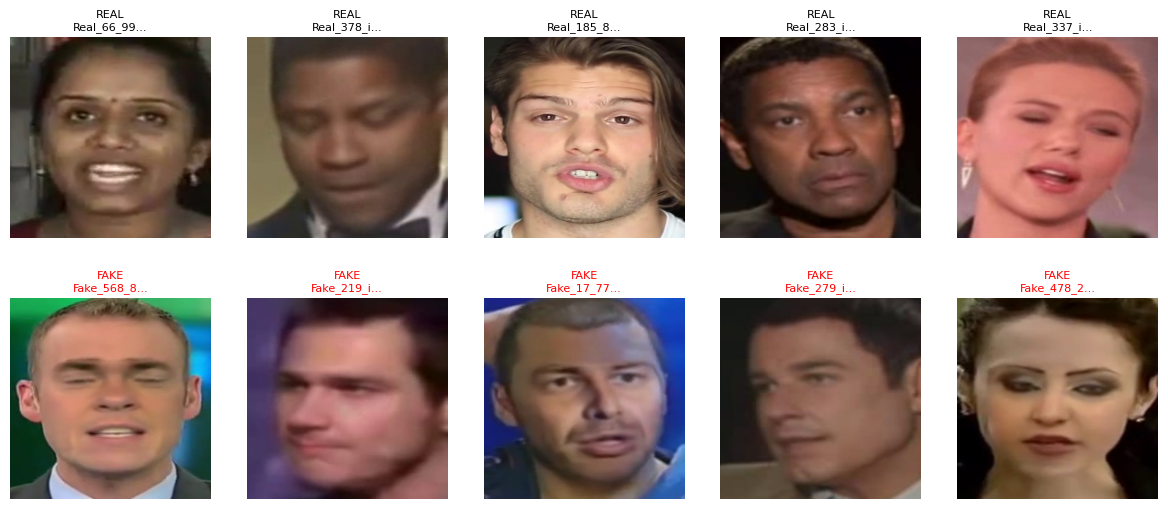

In [6]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image

# --- CONFIGURATION ---
DATA_ROOT = "/kaggle/working/Final_Active_Dataset"
SPLIT = "train" # View images from 'train', 'val', or 'test'

def visualize_samples(root, split, samples_per_class=5):
    real_path = os.path.join(root, split, "Real")
    fake_path = os.path.join(root, split, "Fake")
    
    # check if paths exist
    if not os.path.exists(real_path) or not os.path.exists(fake_path):
        print(f"❌ Error: Could not find directories. Check if {root} exists.")
        return

    # Get list of all video folders
    real_folders = [f.path for f in os.scandir(real_path) if f.is_dir()]
    fake_folders = [f.path for f in os.scandir(fake_path) if f.is_dir()]
    
    if len(real_folders) == 0 or len(fake_folders) == 0:
        print("⚠️ Directories are empty. Run the extraction script first.")
        return

    # Select Random Video Folders
    selected_real = random.sample(real_folders, min(len(real_folders), samples_per_class))
    selected_fake = random.sample(fake_folders, min(len(fake_folders), samples_per_class))
    
    # Plotting
    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 6))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    # --- ROW 1: REAL ---
    for i, vid_folder in enumerate(selected_real):
        # Pick a random frame from this video
        frames = glob.glob(os.path.join(vid_folder, "*.jpg"))
        if frames:
            img_path = random.choice(frames)
            img = Image.open(img_path)
            
            axes[0, i].imshow(img)
            axes[0, i].axis('off')
            axes[0, i].set_title(f"REAL\n{os.path.basename(vid_folder)[:10]}...", fontsize=8)
        else:
            axes[0, i].text(0.5, 0.5, "No Frames", ha='center')

    # --- ROW 2: FAKE ---
    for i, vid_folder in enumerate(selected_fake):
        # Pick a random frame from this video
        frames = glob.glob(os.path.join(vid_folder, "*.jpg"))
        if frames:
            img_path = random.choice(frames)
            img = Image.open(img_path)
            
            axes[1, i].imshow(img)
            axes[1, i].axis('off')
            axes[1, i].set_title(f"FAKE\n{os.path.basename(vid_folder)[:10]}...", fontsize=8, color='red')
        else:
            axes[1, i].text(0.5, 0.5, "No Frames", ha='center')

    print(f"👀 Viewing {samples_per_class} random samples from {split} set...")
    plt.show()

# --- RUN ---
visualize_samples(DATA_ROOT, SPLIT)

In [7]:
import shutil
import os

# --- CONFIGURATION ---
SOURCE_DIR = "/kaggle/working/Final_Active_Dataset"
OUTPUT_FILENAME = "Deepfake_Active_Dataset"  # Will become .zip automatically

print(f"📦 Zipping folder: {SOURCE_DIR}")
print("⏳ This may take 2-5 minutes depending on the size...")

# Create Zip
try:
    shutil.make_archive(OUTPUT_FILENAME, 'zip', SOURCE_DIR)
    print(f"\n✅ SUCCESS! File created: {OUTPUT_FILENAME}.zip")
    print(f"   Size: {os.path.getsize(OUTPUT_FILENAME + '.zip') / (1024*1024):.2f} MB")
    print("⬇️  Go to the 'Output' tab on the right sidebar to download it.")
except Exception as e:
    print(f"❌ Error zipping file: {e}")

📦 Zipping folder: /kaggle/working/Final_Active_Dataset
⏳ This may take 2-5 minutes depending on the size...

✅ SUCCESS! File created: Deepfake_Active_Dataset.zip
   Size: 358.24 MB
⬇️  Go to the 'Output' tab on the right sidebar to download it.


🚀 Training on device: cuda
✅ Loaded 1211 samples for train
✅ Loaded 150 samples for val


/tmp/ipykernel_125/3545931822.py:41: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=100, p=0.3), # Simulate compression
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 154MB/s] 
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



🔥 STARTING TRAINING...


Epoch 1/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.25it/s, loss=0.213] 


   Train Acc: 0.6697 | Loss: 0.5881
   Val Acc:   0.8267 | Loss: 0.4017
   🏆 New Best Model Saved! (0.8267)


Epoch 2/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.24it/s, loss=0.0479]


   Train Acc: 0.8563 | Loss: 0.3513
   Val Acc:   0.9267 | Loss: 0.2331
   🏆 New Best Model Saved! (0.9267)


Epoch 3/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.25it/s, loss=0.156] 


   Train Acc: 0.9133 | Loss: 0.2327
   Val Acc:   0.9200 | Loss: 0.1937


Epoch 4/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.24it/s, loss=0.0213] 


   Train Acc: 0.9315 | Loss: 0.1909
   Val Acc:   0.9467 | Loss: 0.1646
   🏆 New Best Model Saved! (0.9467)


Epoch 5/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.25it/s, loss=0.00861]


   Train Acc: 0.9430 | Loss: 0.1489
   Val Acc:   0.9067 | Loss: 0.2478


Epoch 6/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.24it/s, loss=0.0403] 


   Train Acc: 0.9645 | Loss: 0.0988
   Val Acc:   0.9400 | Loss: 0.1480


Epoch 7/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.24it/s, loss=0.00189] 


   Train Acc: 0.9777 | Loss: 0.0759
   Val Acc:   0.9533 | Loss: 0.1406
   🏆 New Best Model Saved! (0.9533)


Epoch 8/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.24it/s, loss=0.00975] 


   Train Acc: 0.9802 | Loss: 0.0518
   Val Acc:   0.9600 | Loss: 0.1015
   🏆 New Best Model Saved! (0.9600)


Epoch 9/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.25it/s, loss=0.0304]  


   Train Acc: 0.9835 | Loss: 0.0491
   Val Acc:   0.9600 | Loss: 0.1652


Epoch 10/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.25it/s, loss=0.0148]  


   Train Acc: 0.9860 | Loss: 0.0513
   Val Acc:   0.9533 | Loss: 0.1605


Epoch 11/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.25it/s, loss=0.0306]  


   Train Acc: 0.9868 | Loss: 0.0511
   Val Acc:   0.9467 | Loss: 0.1779


Epoch 12/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.24it/s, loss=0.0362]  


   Train Acc: 0.9942 | Loss: 0.0176
   Val Acc:   0.9600 | Loss: 0.1834


Epoch 13/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.25it/s, loss=0.763]   


   Train Acc: 0.9959 | Loss: 0.0157
   Val Acc:   0.9467 | Loss: 0.2112


Epoch 14/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.24it/s, loss=0.000486]


   Train Acc: 0.9942 | Loss: 0.0135
   Val Acc:   0.9667 | Loss: 0.1351
   🏆 New Best Model Saved! (0.9667)


Epoch 15/15 [Train]: 100%|██████████| 303/303 [04:03<00:00,  1.24it/s, loss=0.0016]  


   Train Acc: 0.9942 | Loss: 0.0170
   Val Acc:   0.9667 | Loss: 0.1515


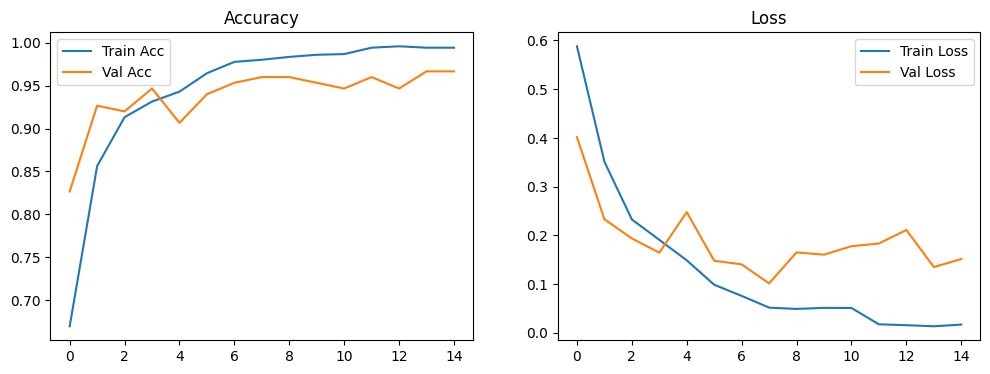

✅ Training Complete. Best model saved as efficientnet_b3_lstm_active.pth


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import glob
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==========================================
# 🔧 HYPERPARAMETERS & CONFIG
# ==========================================
CONFIG = {
    "DATA_ROOT": "/kaggle/working/Final_Active_Dataset",
    "MODEL_NAME": "efficientnet_b3_lstm_active.pth",
    "BATCH_SIZE": 4,          # Small batch size because 20 frames takes lots of VRAM
    "EPOCHS": 15,             # 15 Epochs usually enough for transfer learning
    "LEARNING_RATE": 1e-4,    # Low LR for fine-tuning
    "SEQ_LENGTH": 20,         # Fixed sequence length
    "IMG_SIZE": 224,
    "HIDDEN_DIM": 512,        # LSTM Hidden Dimension
    "BIDIRECTIONAL": True,    # Bidirectional learns forward and backward context
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"🚀 Training on device: {CONFIG['DEVICE']}")

# ==========================================
# 1. ROBUST DATA AUGMENTATION
# ==========================================
# This is crucial for Generalization. We simulate bad internet video quality.
train_transform = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    A.HorizontalFlip(p=0.5),
    A.ImageCompression(quality_lower=60, quality_upper=100, p=0.3), # Simulate compression
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),                       # Simulate blur
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ==========================================
# 2. DATASET LOADER
# ==========================================
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.samples = []
        
        # Gather all video folders
        for label, class_name in enumerate(["Real", "Fake"]):
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_dir): continue
            
            # Each folder represents one video sequence
            video_folders = [f.path for f in os.scandir(class_dir) if f.is_dir()]
            for vid in video_folders:
                # Only add if it has frames
                if len(os.listdir(vid)) > 0:
                    self.samples.append((vid, label))
                    
        print(f"✅ Loaded {len(self.samples)} samples for {split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        vid_path, label = self.samples[idx]
        
        # Get all frames and sort them numerically
        frames = sorted(glob.glob(os.path.join(vid_path, "*.jpg")), 
                        key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))
        
        # Sequence Handling (Pad or Cut to SEQ_LENGTH)
        if len(frames) >= CONFIG['SEQ_LENGTH']:
            # If we have exactly 20 or more, take 20 evenly
            indices = np.linspace(0, len(frames)-1, CONFIG['SEQ_LENGTH'], dtype=int)
            selected_frames = [frames[i] for i in indices]
        else:
            # Padding (Loop the last frame)
            selected_frames = frames + [frames[-1]] * (CONFIG['SEQ_LENGTH'] - len(frames))

        images = []
        for img_path in selected_frames:
            # Read with OpenCV
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Apply Augmentations
            if self.transform:
                augmented = self.transform(image=img)
                images.append(augmented['image'])
        
        # Stack into (SEQ_LEN, 3, 224, 224)
        input_tensor = torch.stack(images)
        return input_tensor, label

# ==========================================
# 3. MODEL ARCHITECTURE
# ==========================================
class EfficientNetLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetLSTM, self).__init__()
        # Backbone
        backbone = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
        # Remove classifier, keep feature extractor
        backbone.classifier = nn.Identity()
        self.feature_extractor = backbone
        
        # EfficientNet-B3 outputs 1536 features
        self.lstm = nn.LSTM(
            input_size=1536, 
            hidden_size=CONFIG['HIDDEN_DIM'], 
            num_layers=1, 
            batch_first=True, 
            bidirectional=CONFIG['BIDIRECTIONAL']
        )
        
        self.dropout = nn.Dropout(0.4)
        
        # Fully Connected Layer
        # If Bidirectional, input is Hidden * 2
        fc_in = CONFIG['HIDDEN_DIM'] * 2 if CONFIG['BIDIRECTIONAL'] else CONFIG['HIDDEN_DIM']
        self.fc = nn.Linear(fc_in, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        
        # CNN Pass: Merge Batch and Sequence dims
        # Input: (Batch, Seq, C, H, W) -> (Batch*Seq, C, H, W)
        c_in = x.view(batch_size * seq_len, c, h, w)
        features = self.feature_extractor(c_in) # Output: (Batch*Seq, 1536)
        
        # Reshape for LSTM: (Batch, Seq, Features)
        features = features.view(batch_size, seq_len, -1)
        
        # LSTM Pass
        lstm_out, _ = self.lstm(features)
        
        # Classification on the last timestep
        last_out = lstm_out[:, -1, :] 
        out = self.dropout(last_out)
        return self.fc(out)

# ==========================================
# 4. TRAINING ENGINE
# ==========================================
def train_model():
    # Load Data
    train_ds = DeepfakeDataset(CONFIG['DATA_ROOT'], "train", train_transform)
    val_ds = DeepfakeDataset(CONFIG['DATA_ROOT'], "val", val_transform)
    
    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)
    
    # Initialize Model
    model = EfficientNetLSTM().to(CONFIG['DEVICE'])
    
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    
    best_acc = 0.0
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    print("\n🔥 STARTING TRAINING...")
    
    for epoch in range(CONFIG['EPOCHS']):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']} [Train]")
        for inputs, labels in loop:
            inputs, labels = inputs.to(CONFIG['DEVICE']), labels.to(CONFIG['DEVICE'])
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            loop.set_postfix(loss=loss.item())
            
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        
        # --- VALIDATE ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(CONFIG['DEVICE']), labels.to(CONFIG['DEVICE'])
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
        val_acc = correct / total
        val_loss = val_loss / len(val_loader)
        
        # --- LOGGING ---
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f"   Train Acc: {train_acc:.4f} | Loss: {train_loss:.4f}")
        print(f"   Val Acc:   {val_acc:.4f} | Loss: {val_loss:.4f}")
        
        # Scheduler Step
        scheduler.step(val_acc)
        
        # Save Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CONFIG['MODEL_NAME'])
            print(f"   🏆 New Best Model Saved! ({val_acc:.4f})")
            
    return history

# ==========================================
# 5. EXECUTE
# ==========================================
if __name__ == "__main__":
    if os.path.exists(CONFIG['DATA_ROOT']):
        history = train_model()
        
        # Plot Results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.legend()
        plt.title('Accuracy')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()
        
        print(f"✅ Training Complete. Best model saved as {CONFIG['MODEL_NAME']}")
    else:
        print("❌ Data directory not found. Please run the extraction script first.")

In [9]:
import os
from IPython.display import FileLink

# Define the model filename
model_filename = "efficientnet_b3_lstm_active.pth"

# Check if it exists before creating the link
if os.path.exists(model_filename):
    print(f"⬇️ Click the link below to download {model_filename}:")
    display(FileLink(model_filename))
else:
    print(f"❌ Error: {model_filename} not found. Did the training finish successfully?")

⬇️ Click the link below to download efficientnet_b3_lstm_active.pth:


/kaggle/working/efficientnet_b3_lstm_active.pth